In [2]:
#standard import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pyreadr

# sklearn
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, HuberRegressor, QuantileRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.utils import resample
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.datasets import make_regression
from sklearn import datasets

# miscilaneous models
from xgboost import XGBRegressor
from quantile_forest import RandomForestQuantileRegressor
from joblib import Parallel, delayed
#from exp_utils import *
import time
from scipy.stats import multivariate_normal
import pickle
from sklearn.neighbors import KNeighborsRegressor
from optbinning import ContinuousOptimalBinning
import openml
from ucimlrepo import fetch_ucirepo 
import os

from imodels.importance import RandomForestPlusRegressor
import blosc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

(CVXPY) Jun 13 02:37:16 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 13 02:37:16 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [5]:
t = {('task_type', 
  'dataset_name', 
  'subsample_frac', 
  'seed', 
  'model_name',
  'featurizer_name',
  'featurizer_frac',
  'featurizer_overlap',
  'depth',
  'pre_interaction',
  'pre_max_features',
  'post_interaction',
  'post_max_features'
 ):
 [(tt,
   dn,
   sf,
   s,
   mn,
   fn,
   ff,
   fo,
   d,
   prei,
   premf,
   posti,
   postmf
  )
 for tt in ['regression', 'classification']
 for dn in ['ca_housing']
 for sf in [0.2]
 for s in [0, 1, 2]
 for mn in ["random_forest", "figs", "xgboost", "resnet", "ft_transformer", "ft_distill"]
 for fn in ["no_featurizer", "featurizer"]
 for ff in [0.25, 0.33, 0.5, 0.75, 1.0]
 for fo in [0, 1]
 for d in [1, 2, 3, 4]
 for prei in ["l0l2", "l1l2"]
 for premf in [0.3, 0.5]
 for posti in ["l0l2", "l1l2"]
 for postmf in [0.3, 0.5]
 ]}

# Data

In [2]:
def process_data(X, y, cat_feat, num_feat):
    # one-hot encode categorical features
    X_processed = pd.get_dummies(X, columns=cat_feat, drop_first=True, dtype=int)
    
    # save categorical features after one-hot encoding
    cat_feat_dummy = X_processed.drop(columns=num_feat).columns.to_numpy()
    
    # get feature importance
    # random forest
    imp_model_rf = RandomForestRegressor(min_samples_leaf = 5, max_features = 0.33, n_estimators = 100, random_state=777)
    feat_imp_rf = imp_model_rf.fit(X_processed, y).feature_importances_

    #rf+
    print("rf+")
    rf_model = RandomForestRegressor(min_samples_leaf = 5, max_features = 0.33, n_estimators = 100, random_state=777)
    imp_model_rf_plus = RandomForestPlusRegressor(rf_model=rf_model)
    imp_model_rf_plus.fit(X_processed,y)
    feat_imp_rf_plus = imp_model_rf_plus.get_mdi_plus_scores(X_processed,y)

    imp_df = pd.DataFrame({"feature": X_processed.columns,
                           "importance_rf": feat_imp_rf,
                           "importance_rf_plus": feat_imp_rf_plus.importance}).sort_values("importance_rf", ascending=False)    
    # bin data
    X_binned = X_processed[num_feat].apply(lambda c: pd.qcut(c, q=4, duplicates="drop"), axis=0)
    X_binned = pd.concat([X_binned, X_processed[cat_feat_dummy]], axis=1)
    
    subgroup_dict = {"num_feat": num_feat,
                    "cat_feat": cat_feat_dummy,
                    "importance": imp_df,
                    "binned_df": X_binned}
    
    return X_processed, y, subgroup_dict

# Abalone
features: 

target:

source:


In [ ]:
data = "data_abalone"
# fetch dataset 
abalone = fetch_ucirepo(id=1) 

# data (as pandas dataframes) 
X_orig = abalone.data.features
y = abalone.data.targets.Rings.to_numpy() 

# specify categorical and numerical features
cat_feat_abalone = ["Sex"]
num_feat_abalone = X_orig.drop(columns = cat_feat_abalone).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_abalone, num_feat_abalone)

bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

In [ ]:
# data = "data_abalone"
# # fetch dataset 
# abalone = fetch_ucirepo(id=1) 

# # data (as pandas dataframes) 
# X_orig = abalone.data.features

# # specify categorical and numerical features
# cat_feat_abalone = ["Sex"]
# num_feat_abalone = X_orig.drop(columns = cat_feat_abalone).columns.to_numpy()

# X_processed = pd.get_dummies(X_orig, columns=cat_feat_abalone, drop_first=True, dtype=int)
# X = X_processed

# # bin data
# abalone_binned = X_orig.drop(columns = cat_feat_abalone).apply(lambda c: pd.cut(c, bins=5), axis=0)
# abalone_binned[cat_feat_abalone] = X_orig[cat_feat_abalone]

# abalone_binned_quantile = X_orig.drop(columns = cat_feat_abalone).apply(lambda c: pd.qcut(c, q=4, duplicates="drop"), axis=0)
# abalone_binned_quantile[cat_feat_abalone] = X_orig[cat_feat_abalone]

# y = abalone.data.targets.Rings.to_numpy() 

# Parkinsons

In [48]:
data = "data_parkinsons"
# fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189) 

# data (as pandas dataframes) 
X_orig = parkinsons_telemonitoring.data.features.drop(columns = "test_time")
y = parkinsons_telemonitoring.data.targets.total_UPDRS.to_numpy()

In [55]:
data = "data_parkinsons"
# fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189) 

# data (as pandas dataframes) 
X_orig = parkinsons_telemonitoring.data.features.drop(columns = "test_time")
y = parkinsons_telemonitoring.data.targets.total_UPDRS.to_numpy()

Text(0.5, 0, 'Speech Oscillation')

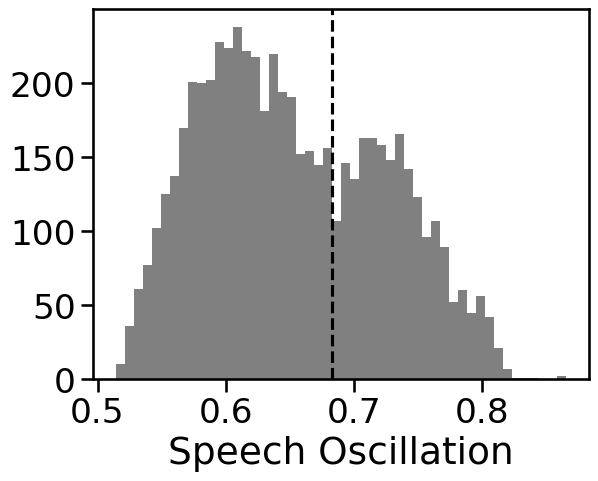

In [49]:
sns.set_context("talk", font_scale=1.5)
plt.hist(X_orig.DFA, bins=50, color="grey")
plt.axvline(0.6827888, color="black", linestyle="dashed")
plt.xlabel("Speech Oscillation")

In [8]:
data = "data_parkinsons"
# fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189) 

# data (as pandas dataframes) 
X_orig = parkinsons_telemonitoring.data.features.drop(columns = "test_time")
y = parkinsons_telemonitoring.data.targets.total_UPDRS.to_numpy()

# save categorical and numerical features
cat_feat_parkinsons = ["sex"]
num_feat_parkinsons = X_orig.drop(columns = cat_feat_parkinsons).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_parkinsons, num_feat_parkinsons)
bin_df = subgroups["binned_df"]

new_bin_df = bin_df.copy(deep=True)
new_bin_df["DFA"] = (X.DFA <= 0.68).astype(int)
subgroups["new_binned_df"] = new_bin_df

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, x_new_bin_train_val, x_new_bin_test, y_train_val, y_test = train_test_split(X, bin_df, new_bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, x_new_bin_train, x_new_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, x_new_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True),
                  "x_new_bin_train": x_new_bin_train.reset_index(drop=True),
                  "x_new_bin_val": x_new_bin_val.reset_index(drop=True),
                  "x_new_bin_test": x_new_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig_new.dat", "wb") as f:
    f.write(pickle_compressed)

rf+


KeyboardInterrupt: 

# Airfoil

In [ ]:
data = "data_airfoil"
# fetch dataset 
airfoil_self_noise = fetch_ucirepo(id=291) 
  
# data (as pandas dataframes) 
X_orig = airfoil_self_noise.data.features 
y = airfoil_self_noise.data.targets["scaled-sound-pressure"].to_numpy()

# save categorical and numerical features
cat_feat_airfoil = []
num_feat_airfoil = X_orig.drop(columns = cat_feat_airfoil).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_airfoil, num_feat_airfoil)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

# Computer

In [ ]:
data = "data_computer"

# fetch dataset
computer = openml.datasets.get_dataset(197)

# data
X_orig, y, cat_ind, col_names = computer.get_data(target=computer.default_target_attribute, dataset_format="dataframe")
y = y.to_numpy()

# save categorical and numerical features
cat_feat_computer = []
num_feat_computer = X_orig.drop(columns = cat_feat_computer).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_computer, num_feat_computer)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

# Concrete

In [ ]:
data = "data_concrete"

# fetch dataset 
concrete_compressive_strength = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X_orig = concrete_compressive_strength.data.features 
y = concrete_compressive_strength.data.targets["Concrete compressive strength"].to_numpy()

# save categorical and numerical features
cat_feat_concrete = []
num_feat_concrete = X_orig.drop(columns = cat_feat_concrete).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_concrete, num_feat_concrete)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

# Powerplant

In [ ]:
data = "data_powerplant"

# fetch dataset 
combined_cycle_power_plant = fetch_ucirepo(id=294) 
  
# data (as pandas dataframes) 
X_orig = combined_cycle_power_plant.data.features 
y = combined_cycle_power_plant.data.targets.PE.to_numpy()

# save categorical and numerical features
cat_feat_powerplant = []
num_feat_powerplant = X_orig.drop(columns = cat_feat_powerplant).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_powerplant, num_feat_powerplant)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

# Miami Housing

In [50]:
# fetch dataset
miami_housing = openml.datasets.get_dataset(43093)

# data
X_orig, y, cat_ind, col_names = miami_housing.get_data(target=miami_housing.default_target_attribute, dataset_format="dataframe")

In [54]:
np.mean(X_orig["WATER_DIST"]<12700)

0.6469997128911857

In [ ]:
plt.hist(X_orig["OCEAN_DIST"], bins=50)

In [ ]:
plt.hist(X_orig["WATER_DIST"], bins=100)
plt.axvline(12700, color="red")

Text(0.5, 0, 'Distance to Water')

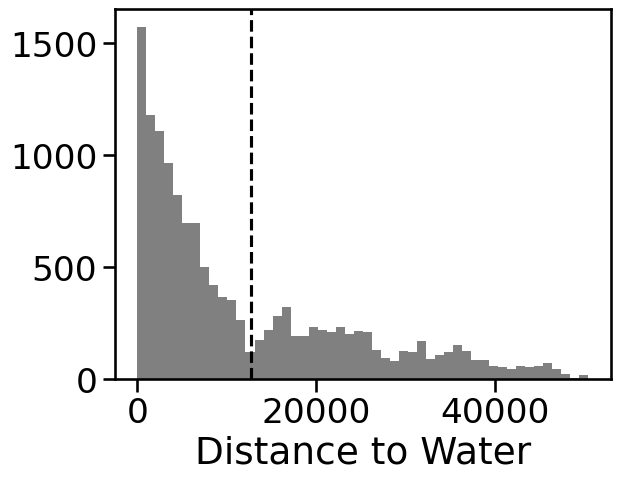

In [22]:
sns.set_context("talk", font_scale=1.5)
plt.hist(X_orig.WATER_DIST, bins=50, color="grey")
plt.axvline(12700, color="black", linestyle="dashed")
plt.xlabel("Distance to Water")

In [ ]:
data = "data_miami_housing"

# fetch dataset
miami_housing = openml.datasets.get_dataset(43093)

# data
X_orig, y, cat_ind, col_names = miami_housing.get_data(target=miami_housing.default_target_attribute, dataset_format="dataframe")
X_orig, y = resample(X_orig, y, replace=False, n_samples=5000, random_state=777)
X_orig = X_orig.drop(columns="PARCELNO").reset_index(drop=True)
y = y.to_numpy()

# save categorical and numerical features
cat_feat_miami_housing = ["avno60plus", "month_sold", "structure_quality"]
num_feat_miami_housing = X_orig.drop(columns = cat_feat_miami_housing).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_miami_housing, num_feat_miami_housing)
bin_df = subgroups["binned_df"]

new_bin_df = bin_df.copy(deep=True)
new_bin_df["WATER_DIST"] = (X.WATER_DIST <= 12700).astype(int)
subgroups["new_binned_df"] = new_bin_df


data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, x_new_bin_train_val, x_new_bin_test, y_train_val, y_test = train_test_split(X, bin_df, new_bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, x_new_bin_train, x_new_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, x_new_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True),
                  "x_new_bin_train": x_new_bin_train.reset_index(drop=True),
                  "x_new_bin_val": x_new_bin_val.reset_index(drop=True),
                  "x_new_bin_test": x_new_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig_new.dat", "wb") as f:
    f.write(pickle_compressed)

# Traffic

In [ ]:
data = "data_traffic"

# fetch dataset 
metro_interstate_traffic_volume = fetch_ucirepo(id=492) 
  
# data (as pandas dataframes) 
X_orig = metro_interstate_traffic_volume.data.features 
y = metro_interstate_traffic_volume.data.targets.traffic_volume.to_numpy() 

# subset data
X_orig["timestamp"] = pd.to_datetime(X_orig.date_time)

# select only 2014 data
year_selector = (X_orig.timestamp.dt.year >= 2013) & (X_orig.timestamp.dt.year <= 2017) 
X_orig = X_orig[year_selector]
y = y[year_selector]

# selec only 8 am data
hour_selector = (X_orig.timestamp.dt.hour >= 7) & (X_orig.timestamp.dt.hour <= 9)
X_orig = X_orig[hour_selector].reset_index(drop=True)
y = y[hour_selector]

# clean data
X_orig = X_orig.drop(columns = ["weather_description", "date_time", "holiday"])
X_orig["year"] = X_orig.timestamp.dt.year
X_orig["month"] = X_orig.timestamp.dt.month
X_orig["hour"] = X_orig.timestamp.dt.hour
X_orig = X_orig.drop(columns = ["timestamp"])

# save categorical and numerical features
cat_feat_traffic = ["weather_main", "year", "month", "hour"]
num_feat_traffic = X_orig.drop(columns = cat_feat_traffic).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_traffic, num_feat_traffic)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

# Insurance

In [ ]:
data = "data_insurance"

# fetch data
insurance = pd.read_csv("https://raw.githubusercontent.com/pycaret/datasets/main/data/common/insurance.csv")

# data
X_orig = insurance.drop(columns="charges")
y = insurance.charges.to_numpy()

# save categorical and numerical features
cat_feat_insurance = ["sex", "smoker", "region"]
num_feat_insurance = X_orig.drop(columns = cat_feat_insurance).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_insurance, num_feat_insurance)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

# CA Housing

In [ ]:
data = "data_ca_housing"

# fetch data
housing = pd.read_csv("../../data/" + "cal_housing.data", delimiter=",", names = ["lon", "lat", "med_age", "total_rooms", "total_beds", "population", "households", "med_income", "med_price"])

# data
X_orig = housing.drop(columns="med_price")
y = housing.med_price.to_numpy()

X_orig, y = resample(X_orig, y, replace=False, n_samples=5000, random_state=777)
X_orig = X_orig.reset_index(drop=True)

# save categorical and numerical features
cat_feat_ca_housing = []
num_feat_ca_housing = X_orig.drop(columns = cat_feat_ca_housing).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_ca_housing, num_feat_ca_housing)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

# QSAR

In [75]:
# fetch dataset
qsar = openml.datasets.get_dataset(4048)

# data
X_orig, y, cat_ind, col_names = qsar.get_data(target=qsar.default_target_attribute, dataset_format="dataframe")
y = y.to_numpy()

(array([  3.,   3.,   2.,   0.,  45.,  78., 176., 284., 351., 232.]),
 array([-0.58999997,  0.4088    ,  1.40759997,  2.40639995,  3.40519992,
         4.40399989,  5.40279987,  6.40159984,  7.40039982,  8.39919979,
         9.39799976]),
 <BarContainer object of 10 artists>)

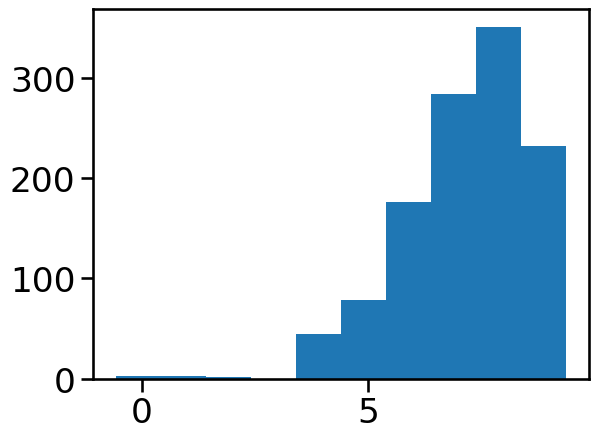

In [76]:
plt.hist(y)

In [ ]:
data = "data_qsar"

# fetch data
qsar = openml.tasks.get_task(360932)

# data
X_orig, y = qsar.get_X_and_y(dataset_format="dataframe")
y = y.to_numpy()

# select features with variance
k = 500
X_array = X_orig.to_numpy()
top_k_columns = X_orig.columns[np.argsort(np.var(X_array, axis=0))[-k:]]
X_orig = X_orig[top_k_columns]

X_orig, y= resample(X_orig, y, replace=False, n_samples=5000, random_state=777)

# save categorical and numerical features
cat_feat_qsar = X_orig.columns.tolist()
num_feat_qsar = X_orig.drop(columns = cat_feat_qsar).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_qsar, num_feat_qsar)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

# Allstate

In [ ]:
data = "data_allstate"

# fetch dataset
allstate = openml.datasets.get_dataset(42571)

# data
X_orig, y, cat_ind, col_names = allstate.get_data(target=allstate.default_target_attribute, dataset_format="dataframe")
y = y.to_numpy()

X_orig, y = resample(X_orig, y, replace=False, n_samples=5000, random_state=777)

# save categorical and numerical features
cat_feat_allstate = np.array(col_names)[cat_ind].tolist()
num_feat_allstate = X_orig.drop(columns = cat_feat_allstate).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_allstate, num_feat_allstate)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

# Mercedes

In [ ]:
data = "data_mercedes"

# fetch dataset
mercedes = openml.datasets.get_dataset(42570)

# data
X_orig, y, cat_ind, col_names = mercedes.get_data(target=mercedes.default_target_attribute, dataset_format="dataframe")
y = y.to_numpy()

# save categorical and numerical features
cat_feat_mercedes = X_orig.columns.tolist()
num_feat_mercedes = X_orig.drop(columns = cat_feat_mercedes).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_mercedes, num_feat_mercedes)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

# Transaction

In [ ]:
data = "data_transaction"

# fetch dataset
transaction = openml.datasets.get_dataset(42572)

# data
X_orig, y, cat_ind, col_names = transaction.get_data(target=transaction.default_target_attribute, dataset_format="dataframe")

# select features with variance
k=500
X_variance = X_orig.var()
top_k_columns = X_variance.sort_values(ascending=False).head(k).index
X_orig = X_orig[top_k_columns]

y = y.to_numpy()

# save categorical and numerical features
cat_feat_transaction = []
num_feat_transaction = X_orig.drop(columns = cat_feat_transaction).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_transaction, num_feat_transaction)
bin_df = subgroups["binned_df"]

In [ ]:
data = "data_transaction"

# fetch dataset
transaction = openml.datasets.get_dataset(42572)

# data
X_orig, y, cat_ind, col_names = transaction.get_data(target=transaction.default_target_attribute, dataset_format="dataframe")

# select features with variance
k=500
X_variance = X_orig.var()
top_k_columns = X_variance.sort_values(ascending=False).head(k).index
X_orig = X_orig[top_k_columns]

y = y.to_numpy()

# save categorical and numerical features
cat_feat_transaction = []
num_feat_transaction = X_orig.drop(columns = cat_feat_transaction).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_transaction, num_feat_transaction)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

# fMRI

In [29]:
data = "data_fMRI"

# data
X_orig = pd.read_csv("../../data/fmri/X.csv")
y = pd.read_csv("../../data/fmri/Y.csv")

In [35]:
y

,x
0,-0.917150
1,-0.398128
2,0.238947
3,-1.932906
4,-1.301263
...,...
37395,0.205281
37396,-0.974765
37397,0.156575
37398,-0.268404


In [32]:
37400 / 1870

20.0

In [ ]:
k=500
X_variance = X_orig.var()
top_k_columns = X_variance.sort_values(ascending=False).head(k).index
X_orig = X_orig[top_k_columns]
X_orig

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_orig, y, test_size=0.2)

In [ ]:
model = LassoCV()
model.fit(x_train, y_train)

In [ ]:
y_pred = model.predict(x_test)
r2_score(y_test, y_pred)

In [ ]:
data = "data_fMRI"

# data
X_orig = pd.read_csv("../../data/fmri/X.csv")
y = pd.read_csv("../../data/fmri/Y.csv").iloc[:X_orig.shape[0], 0]

# select features with variance
k=500
X_variance = X_orig.var()
top_k_columns = X_variance.sort_values(ascending=False).head(k).index
X_orig = X_orig[top_k_columns]

y = y.to_numpy()

# save categorical and numerical features
cat_feat_fmri = []
num_feat_fmri = X_orig.drop(columns = cat_feat_fmri).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_fmri, num_feat_fmri)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig.dat", "wb") as f:
    f.write(pickle_compressed)

# CCLE

In [36]:
X_orig = pd.read_csv("../../data/ccle/X.csv")
y = pd.read_csv("../../data/ccle/Y.csv").loc[:,"Erlotinib"]

In [37]:
y

0      0.29190
1      0.08293
2      0.36970
3      0.22410
4      0.10290
        ...   
365    0.90570
366    0.13850
367    0.84170
368    1.67700
369    0.98100
Name: Erlotinib, Length: 370, dtype: float64

In [ ]:
X_orig = pd.read_csv("../../data/ccle/X.csv")
y = pd.read_csv("../../data/ccle/Y.csv").loc[:,"Erlotinib"]

k=500
X_variance = X_orig.var()
top_k_columns = X_variance.sort_values(ascending=False).head(k).index
X_orig = X_orig[top_k_columns]

model = RidgeCV(alphas=[1,10,100, 1000, 10000])
model.fit(X_orig, y)

In [ ]:
y_pred = model.predict(X_orig)
r2_score(y, y_pred)

In [ ]:
model.intercept_

In [ ]:
data = "data_ccle"

# data
X_orig = pd.read_csv("../../data/ccle/X.csv")
y = pd.read_csv("../../data/ccle/Y.csv").loc[:,"AEW541"]

# select features with variance
k=300
X_variance = X_orig.var()
top_k_columns = X_variance.sort_values(ascending=False).head(k).index
X_orig = X_orig[top_k_columns]

y = y.to_numpy()

# save categorical and numerical features
cat_feat_ccle = []
num_feat_ccle = X_orig.drop(columns = cat_feat_ccle).columns.to_numpy()

X, y, subgroups = process_data(X_orig, y, cat_feat_ccle, num_feat_ccle)
bin_df = subgroups["binned_df"]

data_dict = {}

for i in range(5):
    np.random.seed(777+i)
    x_train_val, x_test, x_bin_train_val, x_bin_test, y_train_val, y_test = train_test_split(X, bin_df, y, test_size=0.2)
    x_train, x_val, x_bin_train, x_bin_val, y_train, y_val = train_test_split(x_train_val, x_bin_train_val, y_train_val, test_size=0.25)
    
    split_dict = {"x_train": x_train.to_numpy(), "y_train": y_train,
                  "x_val": x_val.to_numpy(), "y_val": y_val,
                  "x_test": x_test.to_numpy(), "y_test": y_test,
                  "x_bin_train": x_bin_train.reset_index(drop=True),
                  "x_bin_val": x_bin_val.reset_index(drop=True),
                  "x_bin_test": x_bin_test.reset_index(drop=True)}
    
    data_dict[str(i)] = {"orig": split_dict}

data_dict["subgroup_info"] = subgroups
data_dict["X"] = X
data_dict["y"] = y

if not os.path.exists(f"../data/{data}"):
    os.mkdir(f"../data/{data}")
    
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_orig_300.dat", "wb") as f:
    f.write(pickle_compressed)

# Enhancer

In [67]:
data = "data_enhancer"
with open(f"../data/{data}/data_groups_0.25.pkl", "rb") as f:
    data_dict = pickle.load(f)

In [68]:
data_dict_pickled = pickle.dumps(data_dict)
pickle_compressed = blosc.compress(data_dict_pickled)

with open(f"../data/{data}/data_groups_0.25.dat", "wb") as f:
    f.write(pickle_compressed)

In [3]:
liver = openml.datasets.get_dataset(200)

# data
X_orig, y, cat_ind, col_names = liver.get_data(target=liver.default_target_attribute, dataset_format="dataframe")

In [5]:
X_orig

,D,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17
0,1,1,58.7652,1,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4
1,0,1,56.4463,1,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3
2,1,1,70.0726,0,0,0,0,0.500000,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4
3,1,1,54.7406,1,0,1,1,0.500000,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4
4,0,2,38.1054,1,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1,NaN,67.0000,NaN,NaN,NaN,NaN,0,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,NaN
414,0,NaN,39.0000,NaN,NaN,NaN,NaN,0,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,NaN
415,0,NaN,57.0000,NaN,NaN,NaN,NaN,0,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,NaN
416,0,NaN,58.0000,NaN,NaN,NaN,NaN,0,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,NaN


In [6]:
y

0       400.0
1      4500.0
2      1012.0
3      1925.0
4      1504.0
        ...  
413     681.0
414    1103.0
415    1055.0
416     691.0
417     976.0
Name: class, Length: 418, dtype: float64